In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting Familiar with GenAI Applications in Tech: Notebook 2


| | | |
|-|-|-|

This notebook was forked from ["Text Classification with Generative Models on Vertex AI"](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/prompts/examples/text_classification.ipynb), which was created by [Polong Lin](https://github.com/polong-lin) | [Deepak Moonat](https://github.com/dmoonat). The Colab notebook at that URL has several more compelling text classification use cases for Gemini, so check it out! The official Gemini documentation on classification prompts can be found [here](https://cloud.google.com/vertex-ai/docs/generative-ai/text/classification-prompts).

## Setting Up (note that collapsing all cells will not work as runtime has to restart)



### Install Vertex AI SDK and other required packages

In [1]:
!pip install google-cloud-aiplatform --upgrade -q
!pip install "bigframes<1.0.0" -q
!pip install pandas scikit-learn -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.3/457.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.1 MB/s eta 0:00:00


### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After its restarted, continue to the next step.



In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the cell below to authenticate your environment.


In [1]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment)."


In [2]:
PROJECT_ID = "763235540191"
LOCATION = "us-central1"

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [3]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from vertexai.generative_models import GenerationConfig, GenerativeModel

### Import model

In [4]:
generation_model = GenerativeModel(model_name = "gemini-1.0-pro")

#### Generation config

- Each call that you send to a model includes parameter values that control how the model generates a response. The model can generate different results for different parameter values
- <strong>Experiment</strong> with different parameter values to get the best values for the task

Refer to following [link](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/prompt-design-strategies#experiment-with-different-parameter-values) for understanding different parameters

In [5]:
generation_config = GenerationConfig(temperature=0.1, max_output_tokens=256)

In the section below, you will explore zero-shot prompting, few-shot prompting, and some common types of text classification tasks.

## Getting Started

Let's make sure that the notebook is set up properly via some linguistic fun. Can you identify the language in this text? Can Gemini?

In [6]:
prompt = """
Given a piece of text, classify the language it is written in. Provide only the language name. \n
text: Dum trosekeco oni preĝis en la temploj, ke la drako-reĝo donu pluvon al la homa mondo.
language:
"""

response = generation_model.generate_content(
    contents=prompt, generation_config=generation_config
).text
print(response)

Esperanto


#### Intent recognition

Nice! Now let's see how Gemini handles our intent recognition example from Session 1.

In [7]:
prompt = """
You’re a weather information bot trained to identify a user’s input as one of
the following intents:  “general weather FAQ”, “small talk”, “weather forecast”,
“other”. Respond to the user query by indicating the intent. User query: Is it
raining in LA?
"""

response = generation_model.generate_content(
    contents=prompt, generation_config=generation_config
).text
print(response)

## Intent: Weather Forecast 

The user is asking about the current weather conditions in Los Angeles. 



2 for 2! Let's turn to our exercise: getting Gemini to classify your comments about our weather chatbot

In [8]:
import io
import pandas as pd

your_comments_df = pd.read_csv(io.StringIO('''
Comment,Sentiment
"i asked the bot if it would rain at 5pm and it said no so i went out without my umbrella and then it rained and i got completely soaked, would not recommend",negative
"You can ask it about the current or future temperature, UV index, or precipitation, and it will give you information with references so you can check the answers. Pretty cool",positive
love it,positive
"The bot doesn’t just give you bland information like a weather report would do, but it makes you feel like you are actually in a conversation with someone.",positive
這個氣象APP不夠準確，他說今天不會下雨，但是下午卻下了大雷雨,negative
Works fine but could use improvements. I liked that the weather report was pretty accurate but it couldn’t answer my question about what to wear.,negative
"It turned out to be accurate, but I felt I would not rely on it; I would still check another weather source.",negative
Worked great until the most recent update!!!!1!,negative
This is the only weather bot I will use. Here are some suggestions to the developers for further improvements: add a feature where it outputs a summary based on zip code; allow syncing across multiple devices; include an option for dark mode on iPhone.,positive
"The bot said I didn’t need sunscreen today, so I didn’t apply any. I’m now taking an aloe bath to try and save my skin. Horrible app!",negative
"The bot has predicted rain for the past month. It hasn’t been wrong once, but I’m still pretty unhappy about it!",negative
Everyday is 95 with a chance of afternoon thunderstorms. Duh. This doesn’t tell me anything I didn’t already know.,negative
"Thunderstorms are happening in my area, and I wish I could know how close the lightning is, but it didn’t tell me that.",negative
"Everyday said 95 with a chance of afternoon thunderstorms, and it’s been right! So cool that this is a bot!",positive
It didn’t answer my question.,negative
It gave me a bunch of irrelevant information.,negative
I’d rather talk to a person.,negative
I asked the bot if it would be raining cats and dogs today and it said no. Imagine my surprise when I stepped outside into the pouring rain without my umbrella - I can’t tell if it took my question literally!,negative
I appreciate the bot’s accuracy and will continue using it regularly.,positive
meh,negative
idare eder,positive
I don't know what I would do without it!,positive
it ain't no human,negative
toomuch info,negative
The app keeps showing me ads and wants me to pay! Free app! Not!,negative
Hajur 这个app真是太棒了,positive
Why cant people just go outside and see the weather themselves,negative
este bot es muy divertido y funciona bien la vdd es k me gustó muchichichisimo y lo llamé bob ;),positive
It keeps saying it doesn’t understand. It’s annoying.,negative
Very limited number of responses. There are much better bots out there.,negative
برای سوال‌های ساده و سریع کار رو راه می‌اندازه.,positive
А поумнее б0та вы не могли придумать?,negative
"Нра юзать эту приложуху, разрабы - красавы!",positive
このアプリ最高！毎日使ってる,positive
האפליקציה צריכה עדכון כל שבווע!! סיוט,negative
It was raining outside and the bot still said it was sunny!,negative
Wegen der Scheißapp bin ich jetzt klatschnass!!1! Sofort deinstalliert,negative
"Einfach zu bedienen, klare Informationen, klasse Service!",positive
"Ich bin begeistert, wie höflich die Macher:innen der Applikation mit mir kommunizieren. Die Informationen könnten etwas aktueller sein, aber Höflichkeit schlägt alles, also von mir eine Empfehlung.",positive
"Der wetter-bot iz an oysgezeikhnter hilfsmittel! Er iz zeyer batamter, kenen identifitsiren intents fun forshungen, un derklernt zeyer azoy good. Oyb ir hot a frage vegn dem klimat, temperatur, oder regn, der wetter-bot vet zikh freylekh mitn antshuldikn. A poshet a mekhaye!",positive
"Der wetter-bot iz geven zeyer umhöflek un beleydikend. Er hot nit geantvort af mayne forshungen vi er volt gedarft, un in an ort fun helfn, hot er geshribn beleydikungen. Dos iz nit farvaylendik un zeyer umprofesyonel. Ikh bin zeyer antoysht un vel nit mer banutzn dem bot.",negative
Den katalava tipota,negative
"Καλό app, πολύ χρήσιμο για να ξέρω αν πρέπει να πάρω ομπρέλα το πρώι",positive
"MIN PISTEPSTE TO APP; TO EVGALAN MONO GIA NA MAS MPERDEPSOUN KAI NA MIN KATALAVOUME PWS MAS PSEKAZOUN EDW KAI XRONIA!!!! KANTE TIN EREYNA SAS, KSYPNISTE RE PROVATA!!!!! DEITE TIN ISTOSELIDA MOU GIA PARA PANW PLIRIFORIES!",negative
Bot em i no save long Tok Pisin :(,negative
I was actually looking for an app that was more like helping me to deal with my money issues. This is really bad at that,negative
Ich versteh die ganzen negativen Reviews nicht. Die meisten von den Leuten waren wahrscheinlich einfach zu doof für die Bedienung.,positive
"Yesterday morning I got up and thought to myself I need to buy some bread later today. I didn’t have much time in the morning because I needed to fix the plumbing in the bathroom, but then at noon I already had an appointment to get my eyes tested. Not really sure, what type of frames I want to get for my new glasses. I kind of like the square ones, but my sister told me to get the large round ones. Anyway, I got my bread on the way back home, was stopping by at the supermarket that’s right on the way. Was really hungry by that time, so I had two slices with some spread I picked up the other week at the farmer’s market. Of course, it’s important to stay hydrated as well, so I had a glass of water. And because I was still thirsty, I had another one. You know, I like drinking tap water, the tap water we have here is really good. Anyway, I was scrolling through the Playstore as I was sitting and drinking and that’s how I found the app.",positive
My pohne is getting super hot bruned rihgt through my pocket,negative
My cat is a meteorology genius compared to this app.,negative
Asked if I needed to take an umbrella with me today to work. It said no but it rained,negative
Un po’ scarso in italiano ma le previsioni sono accurate,positive
頼ったら痛い目にあった おかげさまでずぶ濡れアプリ出すんだったらちゃんとしたのを出せ,negative
抱着随便试试的心态用了这个app，没想到比黄大仙还准啊。早上 出门还是大晴天，刚过中午马上开始暴雨，和预报的一模一样。,positive
omg wow!!!!!!!!! another amazing update with fantastic new features that people DEFINITELY wanted!!!!!!!! I love how lsow it is now. /s,negative
$12 a month??????????????? in this economy????????????????? girl.,negative
charged me for sub even after I canceled. customer support no help,negative
omg such a cute lil bot. I would die for her.,positive
It’s a bot. It tells you the weather. It’s okay.,positive
"It did a pretty good job at answering my question in English, pero cuando intenté preguntarle algo en español, quedé mucho menos satisfecho. No supo responder bien",negative
?? why wont this thing do what I want?,negative
'''), header=0)

def get_sentiment(row):
    prompt = f"""Classify the sentiment of the following review as "positive" or "negative". Never respond with anything other than "positive" or "negative".\n\n
                review: {row} \n
                sentiment:
              """
    response = generation_model.generate_content(
        contents=prompt, generation_config=generation_config,

    ).text
    return response


your_comments_df["sentiment_prediction"] = your_comments_df["Comment"].apply(get_sentiment)
your_comments_df.sample(10)


,Comment,Sentiment,sentiment_prediction
60,?? why wont this thing do what I want?,negative,negative
49,My cat is a meteorology genius compared to thi...,negative,negative
25,Hajur 这个app真是太棒了,positive,positive
56,charged me for sub even after I canceled. cust...,negative,negative
34,האפליקציה צריכה עדכון כל שבווע!! סיוט,negative,negative
37,"Einfach zu bedienen, klare Informationen, klas...",positive,positive \n
58,It’s a bot. It tells you the weather. It’s okay.,positive,negative
52,頼ったら痛い目にあった おかげさまでずぶ濡れアプリ出すんだったらちゃんとしたのを出せ,negative,negative
36,Wegen der Scheißapp bin ich jetzt klatschnass!...,negative,negative
38,"Ich bin begeistert, wie höflich die Macher:inn...",positive,positive


In [9]:
your_comments_df["sentiment_prediction"].value_counts()

sentiment_prediction
negative       37
positive \n    11
positive        8
negative \n     4
mixed \n        1
Name: count, dtype: int64

## Uh oh!

If you look carefully at the predicted sentiment labels, we'll probably see that we weren't able to restrict Gemini to "positive" and "negative". This is a real problem in productionization of GenAI models!

In [12]:
# let's fix that by getting rid of the comments with a "mixed" sentiment
# and converting "positive \n" and "negative \n" to "positive" and "negative"
your_comments_df = your_comments_df[your_comments_df["sentiment_prediction"] != "mixed"]
your_comments_df["sentiment_prediction"] = your_comments_df["sentiment_prediction"].str.replace(r' \n', '', regex=True)

your_comments_df["sentiment_prediction"].sample(10)

42    positive
20    negative
38    positive
27    positive
53    positive
30    positive
22    negative
2     positive
15    negative
35    negative
Name: sentiment_prediction, dtype: object

## Now let's calculate precision and recall.

Precision: 1.00
Recall: 0.83


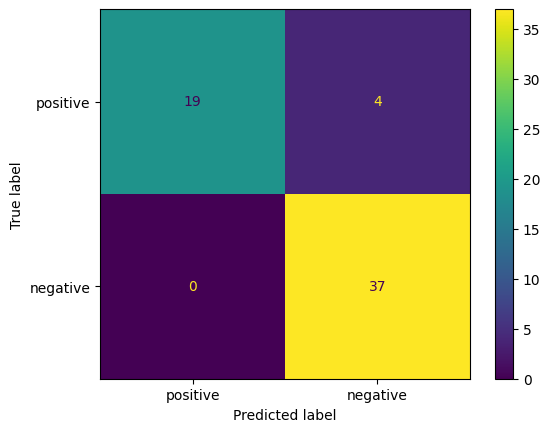

In [13]:
# finally, calculate precision and recall!

cm = confusion_matrix(your_comments_df["Sentiment"],
                      your_comments_df["sentiment_prediction"],
                      labels=["positive", "negative"])


precision = precision_score(your_comments_df["Sentiment"], your_comments_df["sentiment_prediction"], pos_label="positive", average='binary')
recall = recall_score(your_comments_df["Sentiment"], your_comments_df["sentiment_prediction"], pos_label="positive", average='binary')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["positive", "negative"])
disp.plot()

# Print precision and recall
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")